In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import cm
from os.path import exists

ProgressBar().register()

In [2]:
city = 'Cordoba'
city = 'Porto Alegre'
city = 'Buenos Aires'
var = 'tas'
urban_thres = 0.10
land_thres = 0.50
size = 2 # degrees plotted around city center
orog_vlim = dict(vmin=-400, vmax=1500)

loc = {
  'Buenos Aires': dict(
    urb = dict(lat = -34.583, lon = -58.500),
    rur = dict(lat = -34.817, lon = -58.533)  # Ezeiza
  ),
  'Cordoba': dict(
    urb = dict(lat = -31.400, lon = -64.167),
    rur = dict(lat = -31.317, lon = -64.167)
  ),
  'Porto Alegre': dict( # made up points
    urb = dict(lat = -30.032, lon = -51.174),
    rur = dict(lat = -30.152, lon = -51.061)
  ),
}

urls_fx = {
  'UCAN-WRF433' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/CORDEX_output_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx',
  'USP-RegCM471' : 
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/1hr/CORDEX_output_CSAM-4_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_1hr', 
  'ERA5' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_1hr',
  'MSWX' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/observations/CSAM-4i_GloH2O-MSWX_1hr'
}

urls_1hr = {
  'UCAN-WRF433' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/1hr/CORDEX_output_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_1hr',
  'USP-RegCM471' : 
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/1hr/CORDEX_output_CSAM-4_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_1hr', 
  'ERA5' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_1hr',
  'MSWX' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/observations/CSAM-4i_GloH2O-MSWX_1hr'
}

MODIS_LAND_USE = {
  'Urban and built-up': 13,
  'Water bodies': 17
}

In [3]:
ucdb_info = gpd.read_file('data/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
ucdb_city = ucdb_info.query(f'UC_NM_MN =="{city}"').to_crs(crs = 'EPSG:4326')
clon = ucdb_city.centroid.x.values[0]
clat = ucdb_city.centroid.y.values[0]

/tmp/ipykernel_32872/75094153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clon = ucdb_city.centroid.x.values[0]
/tmp/ipykernel_32872/75094153.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clat = ucdb_city.centroid.y.values[0]


In [4]:
source = 'UCAN-WRF433'
fxds = xr.open_dataset(urls_fx[source])
hrds = xr.open_dataset(urls_1hr[source], chunks=dict(rlon=10, rlat=10))

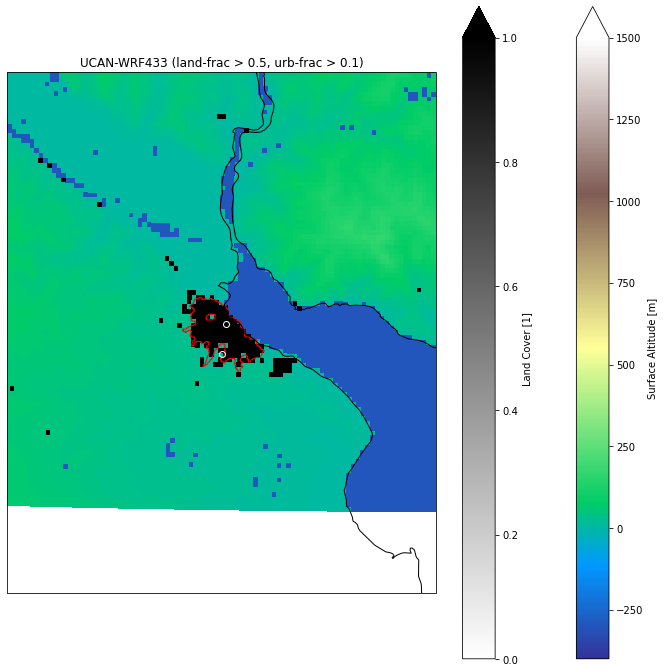

In [5]:
lonlat = ccrs.PlateCarree()
proj = lonlat
f = plt.figure(figsize=(12,12))
ax = plt.axes(projection=proj)
fxds.orog.where(fxds.sftlf == 1).fillna(orog_vlim['vmin']+100).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.terrain, **orog_vlim
)
fxds.landuse.where(fxds.landuse == 13).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.gray_r, vmin=0, vmax=1
)
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
plt.title(f'{fxds.model_id} (land-frac > {land_thres}, urb-frac > {urban_thres})')
lons, lats = list(zip(*[(site['lon'], site['lat']) for site in loc[city].values()]))
ax.plot(lons, lats, 'o', markeredgecolor='w', markerfacecolor='none', transform=lonlat)
ax.coastlines(resolution='10m', linewidth=1, color='k')
ucdb_city.plot(ax=ax, transform=lonlat, facecolor="none", edgecolor="red")
plt.savefig(f'{city.replace(" ","")}_{source}.png')

```python
f = plt.figure(figsize=(12,12))
ax = plt.axes(projection=proj)
fxds.landuse.plot(ax=ax, x='lon', y='lat', transform=lonlat, cmap='tab20c')
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
```

In [6]:
ts = {}
dc = {}
for site in ['urb', 'rur']:
  dist = (fxds['lon']-loc[city][site]['lon'])**2 + (fxds['lat']-loc[city][site]['lat'])**2
  [ilat], [ilon] = np.where(dist == np.min(dist))
  ts[site] = hrds[var].isel(rlat=ilat, rlon=ilon).compute()
  dc[site] = ts[site].groupby('time.hour').mean(dim='time')

[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s


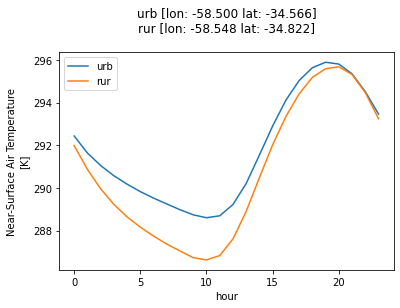

In [7]:
title = ''
sites = ['urb', 'rur']
for site in sites:
  dc[site].plot()
  title += f'{site} [lon: {dc[site].lon.values:.3f} lat: {dc[site].lat.values:.3f}]\n'
plt.title(title)
plt.legend(sites)
plt.savefig(f'UrbRur_{var}_{city.replace(" ","")}_{source}_dc.png')

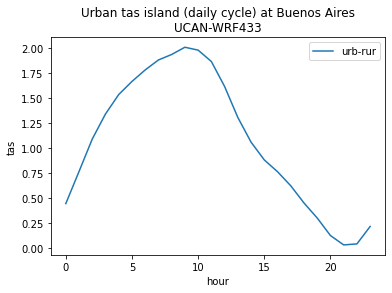

In [9]:
(dc['urb']-dc['rur']).plot()
plt.title(f'Urban {var} island (daily cycle) at {city}\n{source}')
plt.legend(['urb-rur'])
plt.savefig(f'UHI_{var}_{city.replace(" ","")}_{source}_dc.png')